## Imports and Setup

In [1]:
import os
import sys
sys.path.insert(0, "../utils/")
import cnn_utils
import config_utils

import pandas as pd
import numpy as np
import geopandas as gpd

import torchsummary
import torch

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Configuration

In [2]:
iso = "BWA"
config_file = "configs/cnn_configs/convnext_small_v01.yaml"

cwd = os.path.dirname(os.getcwd())
config = config_utils.load_config(os.path.join(cwd, config_file))
config["iso_codes"] = [iso]
data, data_loader, classes = cnn_utils.load_dataset(config, phases=["train", "val", "test"])

INFO:root:Reading file /home/itingzon.unicef/giga/data/vectors/train/BWA_train.geojson
INFO:root:
  rurban  iso       class  count  percentage
0  rural  BWA  non_school    318    0.122026
1  rural  BWA      school    476    0.182655
2  urban  BWA  non_school   1349    0.517652
3  urban  BWA      school    463    0.177667
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  BWA non_school test        37    0.142308
                      train      247         NaN
                      val         34    0.130769
           school     test        42    0.161538
                      train      378         NaN
                      val         56    0.215385
urban  BWA non_school test       132    0.507692
                      train     1092         NaN
                      val        125    0.480769
           school     test        48    0.184615
                      train      381         NaN
                      val    

## Visualize Samples

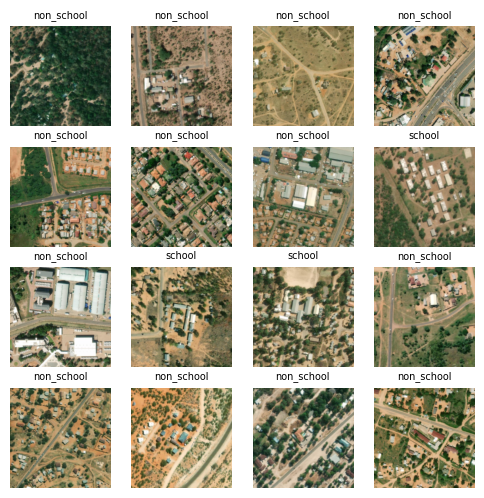

In [3]:
cnn_utils.visualize_data(data, data_loader, phase='train')

## Load Model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=1,
    model_type=config["model"],
    pretrained=config["pretrained"],
    scheduler_type=config["scheduler"],
    optimizer_type=config["optimizer"],
    label_smoothing=config["label_smoothing"],
    lr=config["lr"],
    momentum=config["momentum"],
    gamma=config["gamma"],
    step_size=config["step_size"],
    patience=config["patience"],
    dropout=config["dropout"],
    device=device,
)
torchsummary.summary(model, (3, 500, 500))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 125, 125]           4,704
       LayerNorm2d-2         [-1, 96, 125, 125]             192
            Conv2d-3         [-1, 96, 125, 125]           4,800
           Permute-4         [-1, 125, 125, 96]               0
         LayerNorm-5         [-1, 125, 125, 96]             192
            Linear-6        [-1, 125, 125, 384]          37,248
              GELU-7        [-1, 125, 125, 384]               0
            Linear-8         [-1, 125, 125, 96]          36,960
           Permute-9         [-1, 96, 125, 125]               0
  StochasticDepth-10         [-1, 96, 125, 125]               0
          CNBlock-11         [-1, 96, 125, 125]               0
           Conv2d-12         [-1, 96, 125, 125]           4,800
          Permute-13         [-1, 125, 125, 96]               0
        LayerNorm-14         [-1, 125, 

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.15E-03


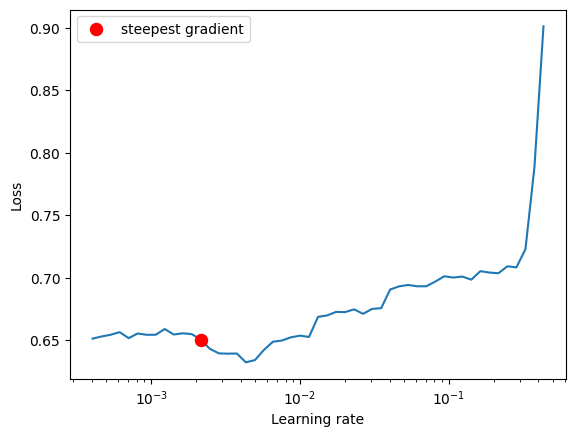

In [5]:
from torch_lr_finder import LRFinder

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data_loader["train"], end_lr=100, num_iter=100)
lr_finder.plot() 
lr_finder.reset()

In [6]:
lrs = np.array(lr_finder.history["lr"])
losses = np.array(lr_finder.history["loss"])

min_grad_idx = None
try:
    min_grad_idx = (np.gradient(np.array(losses))).argmin()
except ValueError:
    print("Failed to compute the gradients, there might not be enough points.")
if min_grad_idx is not None:
    best_lr = lrs[min_grad_idx]

print(f"Best lr:", best_lr)

Best lr: 0.0021544346900318834
